In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras import layers

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [3]:
# setting the working folder to the following path
data_path = '..\\data'
os.chdir(r'..\\data')

os.listdir() # function that returns files in a folder

['Patient 383',
 'Patient 384',
 'Patient 410',
 'Patient 416',
 'Patient 430',
 'Patient 513',
 'Patient 531',
 'Patient 634',
 'Patient 836']

I am in the folder Patient 383
I am in the folder Patient 384
I am in the folder Patient 410
Dimensions target images up to 384 and 308 voxels
0 448
1 448
2 384


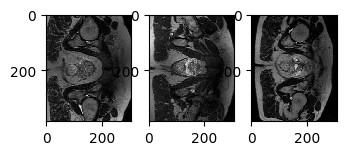

In [4]:
#empty lists to fill with data:
dce = []
t2 = []
adc = []
dwi = []
mask_prost = []
mask_guz = []
for patient in os.listdir(data_path)[0:3]:
    print("I am in the folder %s"%patient)
    for image in os.listdir(data_path+'/'+patient):
        # print("Patient files %s:"%patient, image)
        if 'adc' in image and 'resampled' in image:
            adc.append(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
        elif 'epi' in image and 'resampled' in image:
            dwi_temp = np.squeeze(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
            dwi.append(dwi_temp)
        elif 't2' in image:
            t2.append(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
        elif 't1' in image and 'resampled' in image:
            dce_temp = np.squeeze(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
            elem1 = np.max(dce_temp, 3)
            elem2 = np.argmax(dce_temp, 3)
            new_dce = np.stack((elem1, elem2),-1)
            dce.append(new_dce)
        elif 'cap' in image:
            mask_guz.append(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
        elif 'prostate_mask' in image:
            mask_prost.append(nib.load(data_path+'/'+patient+'/'+image).get_fdata())
        else:
            print("Unexpected file!",image)

# It is necessary to crop images, due to the different sizes of T2-dependent images
# we assume that the images have the same spatial resolution (e.g., 1mmx1mmx1mm)
# In the case of different resolutions, interpolation should be made so that each patient
# had the same resolution of images.

rows = []
cols = []
for patient in t2:
  rows.append(patient.shape[0])
  cols.append(patient.shape[1])

scol = min(cols)
srow = min(rows)
print("Dimensions target images up to %d and %d voxels"%(min(rows), min(cols)))
# Target dimensions of images up to 384 x 308 voxels

for i, patient in enumerate(t2):
    print (i, patient.shape[0])
    col_slice = slice (0, None)
    row_slice = slice (0, None)

    row = patient.shape[0]
    col = patient.shape[1]
    do_cut_row = row-srow
    do_cut_col = col-scol
    if do_cut_col > 0 and do_cut_col% 2 == 0:
        col_slice = slice (do_cut_col//2,-do_cut_col//2)
    elif do_cut_col > 0 and do_cut_col% 2 == 1:
        col_slice = slice (do_cut_col // 2 + 1, -do_cut_col // 2)

    if do_cut_row > 0 and do_cut_row% 2 == 0:
        row_slice = slice (do_cut_row // 2, -do_cut_row // 2)
    elif do_cut_row > 0 and do_cut_row% 2 == 1:
        row_slice = slice (do_cut_row // 2 + 1,-do_cut_row // 2)

    patient_crop = patient [row_slice, col_slice, ...]
    t2[i] = patient_crop

    adc[i] = adc[i][row_slice, col_slice,...]
    dce[i] = dce[i][row_slice, col_slice,...]
    dwi[i] = dwi[i][row_slice, col_slice,...]

    # Cropping des masques
    if mask_guz is not None:
        mask_guz[i] = mask_guz[i][row_slice, col_slice,...]

    if mask_prost is not None:
        mask_prost[i] = mask_prost[i][row_slice, col_slice,...]


# we check the result
plt.figure()
for i,image in enumerate(t2):
    plt.subplot(2,5,i+1)
    plt.imshow(image[:,:, 32], cmap = 'gray', interpolation = 'none', vmin = 0)


In [5]:
t2 = np.array(t2, dtype=np.int64)
adc = np.array(adc, dtype=np.int64)
dce = np.array(dce, dtype=np.int64)
dwi = np.array(dwi, dtype=np.int64)
mask_guz = np.array(mask_guz, dtype=np.int64)
mask_prost = np.array(mask_prost, dtype=np.int64)


t2 = t2.reshape((3, 384, 308, 64, 1))
adc = adc.reshape((3, 384, 308, 64, 1))
mask_guz = mask_guz.reshape((3, 384, 308, 64, 1))
mask_prost = mask_prost.reshape((3, 384, 308, 64, 1))


data = np.concatenate((t2, adc, dce, dwi), axis=4)
data = np.concatenate([data[i] for i in range(data.shape[0])], axis=2)
data = np.moveaxis(data, 2, 0)
del t2
del adc
del dce
del dwi

In [64]:
from sklearn.model_selection import train_test_split

mask = np.concatenate([mask_guz[i] for i in range(mask_guz.shape[0])], axis=2)
mask = np.moveaxis(mask, 2, 0)
print(mask.shape)

X = data
X = np.pad(X, ((0, 0), (0, 0), (2, 2), (0, 0)))
X = X / 2888

y = np.pad(mask, ((0, 0), (0, 0), (2, 2), (0, 0)))
y = y / 255


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

(192, 384, 308, 1)


In [63]:
flat = y.flatten()
mx = flat.argmax()
print(flat[mx])


255


In [65]:
def get_model(img_size, num_classes):
    inputs = layers.Input(shape=img_size)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(2, (3,3), activation="softmax", padding="same")(x)
    # outputs = layers.Cropping2D(((0, 0), (0, 4)))(outputs)
    print(inputs.shape, outputs.shape)
    # Define the model
    model = keras.Model(inputs, outputs)
    return model




In [66]:
model = get_model(X.shape[1:], 2)
# print(model.summary())
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy') # , metrics=['precision']

(None, 384, 312, 10) (None, 384, 312, 2)


In [ ]:
model.fit(x=X_train, y=y_train, batch_size=5, epochs=10)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.7381
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 0.0391
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 0.0138
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.0111
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.0129
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.0079
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.0057
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.0042
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.0066
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 0.0029
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 0.0016
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 0.0024
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 0.0022
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 9.8694e-04
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.0016


KeyboardInterrupt: 